# The Rosetta Workflow Service

The Rosetta workflower API executes a multi-step description of a biomedical question.

It does this by applying user supplied arguments to inform a workflow script.

The environment executes workflow operators, managing job interactions (sometimes referred to as "handoff") and returns the output of the process.


### Language

- A workflow is a series of steps.
- Each step can reference a predefined operation via the **code** tag.
   - These operations accept a set of arguments specified via the **args** tag.
   - When an operation executes, its result is implicitly stored and can be addressed later by the operator's name.

### Variables

Variables passed to the workflow can be resolved dynamically. In this example, **$disease_name** refers to an argument provided by the execution context to this workflow. The provided value will be substituted at runtime.

```
  diseases:
    doc: |
      Analogous English to ontological identifier transformation for disease.
    code: name2id
    args:
      type: disease
      input: $disease_name
```

### Query

- An operation may query the output of a previous step.
- In this way, a "list" of genes can be created by querying a structure produced elsewhere in the workflow.
- The language currently supports a **select** tag, which, in conjunction with **from** and **where** tags is used to target a JSONPath expression at the output of a previous step.

In the example below, the output of the name2id service is indexed by the drug_to_phenotypic_feature operation using a JSONPath expression. That job is an instance of the gamma job for querying the Gamma (Robokop) reasoner.

### Operators

There are currently four built in operators: ```name2id, gamma, union, and get```

- **name2id** Invokes the Bionames API to resolve a natural language string to ontology identifiers.
- **gamma** Invokes the Gamma reasoner. The example below calls Gamma a few times with different machine questions. It will be updated to use the new Quick API for added flexibility. 
- **union** Unions two or more results into one object.
- **get** Invokes an HTTP GET operation on a specified resource.

We expect to grow this capability in two ways:
- **Adding Core Operators**: By adding intersection and other common graph operations, we can increase the basic capability.
- **Templates** The following section describes how users can compose and extend operations to creat their own.
    
### Templates

Templates allow the extension and specialization of existing library functions.

```
templates:
  name2id:
    doc: |
      This is a template. It can be extended by other templates or by operators. 
    code: get
    args:
      pattern: 'https://bionames.renci.org/lookup/{input}/{type}/'
workflow:
  drugs:
    doc: |
      This template accepts a $drug_name variable and specifies the biolink model type for chemical substances.
    extends: name2id
    args:
      inputs:
        - input: $drug_name
          type: chemical_substance
...
```

### Modules

External modules can be loaded via the import tag.

This module definition, 

```
doc: |
  This module defines a reusable template.
  It can be imported into other workflows via the import directive.

templates:

  name2id:
    doc: |
      This is a template. It can be extended by workflow operators.
      An extending operator will have all attributes of this template. 
    code: get
    args:
      pattern: 'https://bionames.renci.org/lookup/{input}/{type}/'
```

saved to a file called bionames.ros on the module path, can be loaded from another module like this

```
import:
  - bionames
```

and its components referenced by the importing workflow like this:

```
  drugs:
    doc: |
      This template accepts a $drug_name variable and specifies the biolink model type for chemical substances.
    extends: name2id
    args:
      inputs:
        - input: $drug_name
          type: chemical_substance
```

### Execution

There are two basic execution modes.

- **Synchronous** The prototype runs jobs synchronously.
- **Asynchronous** Under development is a task queue based approach.
  - The engine builds a directed acyclic graph (DAG) of jobs.
  - A topological sort of the jobs provides the execution order.
  - Each job is sent, via an AMQP message queue to an execution back end (Celery).
  - Job results are stored in Redis. 
- Ultimately, other back ends would be good. Currently investigating FireWorks.

### Openness

- A central goal is to be open to invoking all Translator services.
- We hope to do this by providing a core of services that can be composed into new services.


In [4]:
workflow_text = """
workflow:

  drugs:
    doc: |
      Demonstrates an biolink-model enabled name to ID resolution interface using Bionames.
      For all operators, we store the result in a result node that can be referenced by subsequent steps.
    code: name2id
    args:
      type: chemical_substance
      input: $drug_name

  diseases:
    doc: |
      Analogous English to ontological identifier transformation for disease.
    code: name2id
    args:
      type: disease
      input: $disease_name

  drug_to_phenotypic_feature:
    doc: |
      Selects elements from the previous result, forms a machine question, and queries Gamma.
      The inputs arg supports a select language using
         select - A jsonpath_rw to index into the response of the previous step
         from   - The name of a completed worflow step
         where  - An equality expression constraining values of a selected column
         return - Required with where. Specifies which column to return
      Construct a machine question based on the given transtions in the question.
      For now, assume all edges flow in one direction from start type to end type.
      Create input nodes based on the type of the first element in transitions.
      For the nodes portion of the graph, create nodes with sequential ids for each element of transitions
    code: gamma
    args:
      inputs:
        select: $.[*].id
        from: drugs
      question:
        transitions:
          - drug
          - gene
          - biological_process_or_activity
          - cell

  disease_to_phenotypic_feature:
    doc: |
      A chained Gamma query.
    code: gamma
    args:
      inputs:
        select: $.[*].id
        from:   diseases
      question:
        transitions:
          - disease
          - phenotypic_feature

  disease_to_gene:
    doc: |
      A chained Gamma query with a more complex select statement.
    code: gamma
    args:
      inputs:
        select: $.[*].id
        from:   diseases
      question:
        transitions:
          - disease
          - gene

  return:
    doc: |
      Union answers from preceeding steps.
    code: union
    args:
      elements:
        - drug_to_phenotypic_feature
        - disease_to_phenotypic_feature
        - disease_to_gene
"""

rosetta_host = "rosetta.renci.org"

### Calling the Workflow API
Define an function for invoking the Rosetta Workflow API.

We just read the workflow above as YAML, then post it to the service's single endpoint.

In this prototype, arguments are hard coded server side. In the future, they'll be posted with the workflow.

In [5]:
import requests
import yaml
import json

def execute_workflow ():
    workflow = yaml.load (workflow_text)
    url=f'https://{rosetta_host}/api/executeWorkflow'
    response = requests.post(url, json=workflow)
    print( f"Return Status: {response.status_code}" )
    if response.status_code == 200:
        return response.json()
    return response

In [30]:
val = execute_workflow ()

Return Status: 200


### Workflow Results
We've run the workflow successfully. We'll set up a couple of utility functions to have a look at what we got.

In [69]:
def short_text(text, max_len=85):
    return (text[:max_len] + '..') if len(text) > max_len else text
def short (obj, max_len=800):
    text = json.dumps(obj, indent=2)
    return short_text (text, max_len)

In [70]:
print (f"{short(val)}")

[
  {
    "answers": [
      {
        "id": null,
        "answerset": null,
        "natural_answer": null,
        "nodes": [
          {
            "id": "CHEBI:49375",
            "equivalent_identifiers": [
              "HMDB:HMDB0015384",
              "DRUGBANK:DB01254",
              "UNII:X78UG0A0RN",
              "CHEBI:49375",
              "CHEMBL:CHEMBL1421",
              "PUBCHEM:3062316"
            ],
            "type": "drug",
            "omnicorp_article_count": 0
          },
          {
            "equivalent_identifiers": [
              "NCBIGENE:2048",
              "EC:2.7.10.1",
              "HGNC:3393",
              "ENSEMBL:ENSG00000133216"
            ],
            "name": "EPHB2",
            "id": "HGNC:3393",
            "type": "gene",
           ..


In [77]:
import pandas as pd

def parse_answer(the_answer):  
    nodes = [answer['nodes'][1] for answer in the_answer['answers']]
    edges = [answer['edges'][0] for answer in the_answer['answers']]
    answers = [ {"result_id": node["id"], 
                 "result_name": node["name"], 
                 "type": edge["type"],
                 "source": edge['edge_source']}
              for node,edge in zip(nodes,edges)]
    return answers

def parse_answer_sets(answer_sets):
    answers = []
    for obj in answer_sets:
        answers = answers + parse_answer (obj)    
    return pd.DataFrame (answers)

In [78]:
parse_answer_sets (val)

,result_id,result_name,source,type
0,HGNC:3393,EPHB2,pharos.drug_get_gene,directly_interacts_with
1,HGNC:3393,EPHB2,pharos.drug_get_gene,directly_interacts_with
2,HGNC:3392,EPHB1,pharos.drug_get_gene,directly_interacts_with
3,HGNC:3392,EPHB1,pharos.drug_get_gene,directly_interacts_with
4,HGNC:3386,EPHA2,pharos.drug_get_gene,directly_interacts_with
5,HGNC:3386,EPHA2,hmdb.metabolite_to_enzyme,interacts_with
6,HGNC:3393,EPHB2,pharos.drug_get_gene,directly_interacts_with
7,HGNC:3431,ERBB3,pharos.drug_get_gene,directly_interacts_with
8,HGNC:3393,EPHB2,pharos.drug_get_gene,directly_interacts_with
9,HGNC:3386,EPHA2,pharos.drug_get_gene,directly_interacts_with


### The Directed Acyclic Graph (DAG)
DAGs are frequently used to model workflows in systems like Condor and others.

They provide a basis for an execution model that governs dependencies and parallelism.

Rosetta workflows calculate a DAG when they're loaded.

In the example below, we load a workflow passing a library path in which dependencies can be resolved.

We then use the workflow's DAG to draw its dependencies.

The DAG also provides a graph based approach for analyzing the structure of Translator workflow questions.


importing module: bionames from /Users/scox/dev/reasoner-tools/greent/flow/bionames.ros


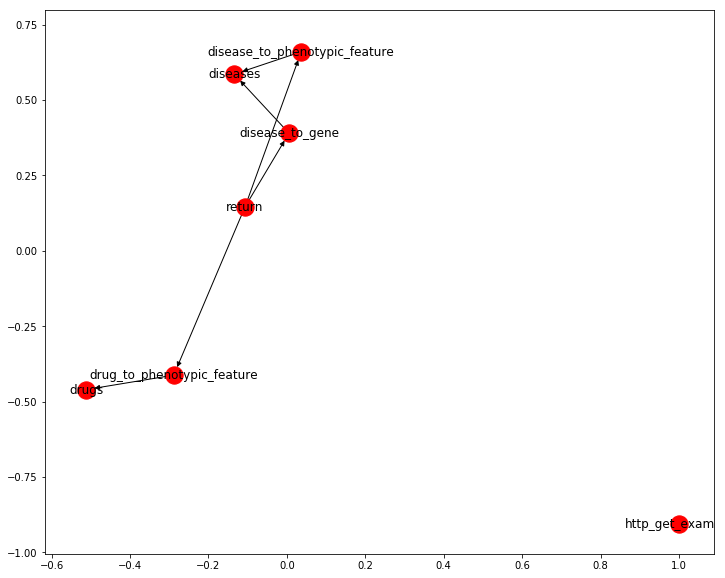

In [3]:
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from greent.flow.rosetta_wf import Workflow
workflow_path = "/Users/scox/dev/reasoner-tools/greent/flow/mq2.ros"
workflow_libs = [ "/Users/scox/dev/reasoner-tools/greent/flow" ]
workflow = Workflow.get_workflow (workflow_path, library_path=workflow_libs)
g = workflow.dag
fig, ax = plt.subplots(1, 1, figsize=(12, 10));
nx.draw_networkx(g, ax=ax)